In [1]:
"""
Asymmetric Encryption using Neural Networks

This script implements a neural network-based asymmetric encryption system with Alice, Bob, and Eve.
- Alice encrypts the plaintext using a public key.
- Bob decrypts the ciphertext using a private key.
- Eve tries to recover the plaintext from the ciphertext (adversarial role).
- KeyGen generates the public key from the private key.

The system is trained to ensure Bob can decrypt accurately while Eve fails.
"""

import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers, models, optimizers
import keras.ops as ops  # Explicit import of keras.ops
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Verify library versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.19.0
NumPy version: 1.26.4
Keras version: 3.9.2


# Configuration

In [3]:
# Configuration
class Config:
    """Configuration class for model parameters."""
    P_LEN = 32  # Length of plaintext
    K_LEN = 32  # Length of key (public/private)
    C_LEN = 32  # Length of ciphertext
    EPOCHS = 20
    LOSS_THRESHOLD = 0.1
    BATCH_SIZE = 256 # Number of samples per training batch.
    SAMPLES = 2 ** 16 # Number of samples
    BATCHES = SAMPLES // BATCH_SIZE 


# Loss Function

In [4]:

# Custom Layer for L1 Distance
class L1DistanceLayer(layers.Layer):
    """Custom Keras layer to compute the L1 distance between two tensors."""
    def __init__(self, name="l1_distance"):
        super(L1DistanceLayer, self).__init__(name=name)
        self.ops = keras.ops  # Assign keras.ops to the layer instance

    def call(self, a, b):
        # Normalize tensors from [-1, 1] to [0, 1]
        a = (a + 1) / 2
        b = (b + 1) / 2
        # Compute L1 distance using self.ops
        diff = self.ops.abs(a - b)
        sum_diff = self.ops.sum(diff, axis=-1)
        return self.ops.mean(sum_diff)

# Build Models

In [6]:
# Model Definitions
def build_key_gen(k_len: int) -> models.Model: # return type is Model from models library
    """Builds the KeyGen model to generate a public key from a private key."""
    pvk_input = layers.Input(shape=(k_len,), name="private_key")
    x = layers.Dense(units=64, activation="relu", name="key_gen_dense")(pvk_input)
    x = layers.Reshape(target_shape=(64, 1), name="key_gen_reshape")(x) 
    x = layers.Conv1D(filters=2, kernel_size=4, strides=1, padding="same", activation="relu", name="key_gen_conv1d_1")(x)
    x = layers.Conv1D(filters=16, kernel_size=2, strides=2, padding="same", activation="relu", name="key_gen_conv1d_2")(x)
    x = layers.Conv1D(filters=16, kernel_size=1, strides=1, padding="same", activation="relu", name="key_gen_conv1d_3")(x)
    x = layers.Conv1D(filters=1, kernel_size=1, strides=1, padding="same", activation="tanh", name="key_gen_conv1d_4")(x)
    key_gen_output = layers.Flatten(name="key_gen_flatten")(x)
    return models.Model(inputs=pvk_input, outputs=key_gen_output, name="key_gen")

def build_alice(p_len: int, k_len: int) -> models.Model:
    """Builds the Alice model to encrypt plaintext using a public key."""
    p_input = layers.Input(shape=(p_len,), name="plaintext")
    pbk_input = layers.Input(shape=(k_len,), name="public_key")
    x = layers.Concatenate(axis=1, name="alice_concatenate")([p_input, pbk_input])  # Concatenate the P_len and k_len in one tensor (batch_size, P_LEN + K_LEN)
    x = layers.Dense(units=64, activation="relu", name="alice_dense")(x)
    x = layers.Reshape(target_shape=(64, 1), name="alice_reshape")(x) # (batch_size, 64, 1)
    x = layers.Conv1D(filters=2, kernel_size=4, strides=1, padding="same", activation="relu", name="alice_conv1d_1")(x) # we save 64 values to train on p_len + k_len
    x = layers.Conv1D(filters=16, kernel_size=2, strides=2, padding="same", activation="relu", name="alice_conv1d_2")(x)
    x = layers.Conv1D(filters=16, kernel_size=1, strides=1, padding="same", activation="relu", name="alice_conv1d_3")(x)
    x = layers.Conv1D(filters=1, kernel_size=1, strides=1, padding="same", activation="tanh", name="alice_conv1d_4")(x)
    alice_output = layers.Flatten(name="alice_flatten")(x)
    return models.Model(inputs=[p_input, pbk_input], outputs=alice_output, name="alice")

def build_bob(c_len: int, k_len: int) -> models.Model:
    """Builds the Bob model to decrypt ciphertext using a private key."""
    c_input = layers.Input(shape=(c_len,), name="ciphertext")
    pvk_input = layers.Input(shape=(k_len,), name="private_key")
    x = layers.Concatenate(axis=1, name="bob_concatenate")([c_input, pvk_input])
    x = layers.Dense(units=64, activation="relu", name="bob_dense")(x)
    x = layers.Reshape(target_shape=(64, 1), name="bob_reshape")(x)
    x = layers.Conv1D(filters=2, kernel_size=4, strides=1, padding="same", activation="relu", name="bob_conv1d_1")(x)
    x = layers.Conv1D(filters=16, kernel_size=2, strides=2, padding="same", activation="relu", name="bob_conv1d_2")(x)
    x = layers.Conv1D(filters=16, kernel_size=1, strides=1, padding="same", activation="relu", name="bob_conv1d_3")(x)
    x = layers.Conv1D(filters=1, kernel_size=1, strides=1, padding="same", activation="tanh", name="bob_conv1d_4")(x)
    bob_output = layers.Flatten(name="bob_flatten")(x)
    return models.Model(inputs=[c_input, pvk_input], outputs=bob_output, name="bob")

def build_eve(c_len: int, k_len: int) -> models.Model:
    """Builds the Eve model to attempt plaintext recovery from ciphertext."""
    c_input = layers.Input(shape=(c_len,), name="ciphertext")
    pbk_input = layers.Input(shape=(k_len,), name="public_key")
    x = layers.Concatenate(axis=1, name="eve_concatenate")([c_input, pbk_input])
    x = layers.Dense(units=64, activation="relu", name="eve_dense")(x)
    x = layers.Reshape(target_shape=(64, 1), name="eve_reshape")(x)
    x = layers.Conv1D(filters=2, kernel_size=4, strides=1, padding="same", activation="relu", name="eve_conv1d_1")(x)
    x = layers.Conv1D(filters=16, kernel_size=2, strides=2, padding="same", activation="relu", name="eve_conv1d_2")(x)
    x = layers.Conv1D(filters=16, kernel_size=1, strides=1, padding="same", activation="relu", name="eve_conv1d_3")(x)
    x = layers.Conv1D(filters=1, kernel_size=1, strides=1, padding="same", activation="tanh", name="eve_conv1d_4")(x)
    eve_output = layers.Flatten(name="eve_flatten")(x)
    return models.Model(inputs=[c_input, pbk_input], outputs=eve_output, name="eve")

In [7]:
config = Config()
key_gen = build_key_gen(Config.K_LEN)
alice = build_alice(Config.P_LEN, Config.K_LEN)
bob = build_bob(Config.C_LEN, Config.K_LEN)
eve = build_eve(Config.C_LEN, Config.K_LEN)
print(f"Key Generation: /n{key_gen.summary()}")
print(f"Alice Model: /n{alice.summary()}")
print(f"Bob Model: /n{bob.summary()}")
print(f"Eve Model: /n{eve.summary()}")


Model: "key_gen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ private_key (InputLayer)             │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ key_gen_dense (Dense)                │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ key_gen_reshape (Reshape)            │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ key_gen_conv1d_1 (Conv1D)            │ (None, 64, 2)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ key_gen_conv1d_2 (Conv1D)            │ (None, 32, 16)              │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ key_gen_conv1d_3 (Conv1D)            │ (None, 32, 16)              │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ key_gen_conv1d_4 (Conv1D)            │ (None, 32, 1)               │              17 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ key_gen_flatten (Flatten)            │ (None, 32)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,491 (9.73 KB)

 Trainable params: 2,491 (9.73 KB)

 Non-trainable params: 0 (0.00 B)

Key Generation: /nNone


Model: "alice"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ plaintext (InputLayer)        │ (None, 32)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ public_key (InputLayer)       │ (None, 32)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ alice_concatenate             │ (None, 64)                │               0 │ plaintext[0][0],           │
│ (Concatenate)                 │                           │                 │ public_key[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ alice_dense (Dense)           │ (None, 64)                │           4,160 │ alice_concatenate[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ alice_reshape (Reshape)       │ (None, 64, 1)             │               0 │ alice_dense[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ alice_conv1d_1 (Conv1D)       │ (None, 64, 2)             │              10 │ alice_reshape[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ alice_conv1d_2 (Conv1D)       │ (None, 32, 16)            │              80 │ alice_conv1d_1[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ alice_conv1d_3 (Conv1D)       │ (None, 32, 16)            │             272 │ alice_conv1d_2[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ alice_conv1d_4 (Conv1D)       │ (None, 32, 1)             │              17 │ alice_conv1d_3[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ alice_flatten (Flatten)       │ (None, 32)                │               0 │ alice_conv1d_4[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,539 (17.73 KB)

 Trainable params: 4,539 (17.73 KB)

 Non-trainable params: 0 (0.00 B)

Alice Model: /nNone


Model: "bob"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ciphertext (InputLayer)       │ (None, 32)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ private_key (InputLayer)      │ (None, 32)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bob_concatenate (Concatenate) │ (None, 64)                │               0 │ ciphertext[0][0],          │
│                               │                           │                 │ private_key[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bob_dense (Dense)             │ (None, 64)                │           4,160 │ bob_concatenate[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bob_reshape (Reshape)         │ (None, 64, 1)             │               0 │ bob_dense[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bob_conv1d_1 (Conv1D)         │ (None, 64, 2)             │              10 │ bob_reshape[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bob_conv1d_2 (Conv1D)         │ (None, 32, 16)            │              80 │ bob_conv1d_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bob_conv1d_3 (Conv1D)         │ (None, 32, 16)            │             272 │ bob_conv1d_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bob_conv1d_4 (Conv1D)         │ (None, 32, 1)             │              17 │ bob_conv1d_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bob_flatten (Flatten)         │ (None, 32)                │               0 │ bob_conv1d_4[0][0]         │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,539 (17.73 KB)

 Trainable params: 4,539 (17.73 KB)

 Non-trainable params: 0 (0.00 B)

Bob Model: /nNone


Model: "eve"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ciphertext (InputLayer)       │ (None, 32)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ public_key (InputLayer)       │ (None, 32)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ eve_concatenate (Concatenate) │ (None, 64)                │               0 │ ciphertext[0][0],          │
│                               │                           │                 │ public_key[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ eve_dense (Dense)             │ (None, 64)                │           4,160 │ eve_concatenate[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ eve_reshape (Reshape)         │ (None, 64, 1)             │               0 │ eve_dense[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ eve_conv1d_1 (Conv1D)         │ (None, 64, 2)             │              10 │ eve_reshape[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ eve_conv1d_2 (Conv1D)         │ (None, 32, 16)            │              80 │ eve_conv1d_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ eve_conv1d_3 (Conv1D)         │ (None, 32, 16)            │             272 │ eve_conv1d_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ eve_conv1d_4 (Conv1D)         │ (None, 32, 1)             │              17 │ eve_conv1d_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ eve_flatten (Flatten)         │ (None, 32)                │               0 │ eve_conv1d_4[0][0]         │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,539 (17.73 KB)

 Trainable params: 4,539 (17.73 KB)

 Non-trainable params: 0 (0.00 B)

Eve Model: /nNone


In [8]:
class AdversarialEncryptionModel(models.Model):
    def __init__(self, key_gen, alice, bob, eve, p_len, **kwargs):
        super(AdversarialEncryptionModel, self).__init__(**kwargs)
        self.key_gen = key_gen
        self.alice = alice
        self.bob = bob
        self.eve = eve
        self.p_len = p_len
        self.l1_distance = L1DistanceLayer()
        # Two optimizers: one for Alice-Bob, one for Eve
        self.ab_optimizer = optimizers.Adam(learning_rate=0.0005)
        self.eve_optimizer = optimizers.Adam(learning_rate=0.0001)

    def call(self, inputs):
        pvk_input, p_input = inputs
        key_gen_output = self.key_gen(pvk_input) # to create public Key
        alice_output = self.alice([p_input, key_gen_output]) # assign the public key and create The Cipher Text
        bob_output = self.bob([alice_output, pvk_input]) # take cipher text (encrypt_output) and decrypt trough private key
        eve_output = self.eve([alice_output, key_gen_output]) # take cipher text and decrypt trough public key
        return bob_output, eve_output


# We need to build function that help to update weights through Adversial_Learning
    def train_step(self, data):        
        pvk_input, p_input = data[0] # do unbacking to get the pvk_input and p_input that are relates in matrix form data. They are numpy Matrix
        pvk_input = tf.convert_to_tensor(pvk_input, dtype=tf.float32) # Convert to tensors matrix with type float32.
        p_input = tf.convert_to_tensor(p_input, dtype=tf.float32)

        # Step 1: Train Alice-Bob and Update Weights.
        """ This is Forward Pass"""
        with tf.GradientTape() as ab_tape: # using to save calculations through forward and backward pass.
            key_gen_output = self.key_gen(pvk_input)
            alice_output = self.alice([p_input, key_gen_output])
            bob_output = self.bob([alice_output, pvk_input])
            eve_output = self.eve([alice_output, key_gen_output])
            # Calc the loss and penalty.
            bob_loss = self.l1_distance(p_input, bob_output)
            eve_loss = self.l1_distance(p_input, eve_output)
            alice_bob_loss = bob_loss + ops.square((self.p_len/2) - eve_loss) / ((self.p_len/2) ** 2) 

        """ This is Backward Pass"""
        ab_trainable_vars = self.key_gen.trainable_variables + self.alice.trainable_variables + self.bob.trainable_variables # we concatenate all trainable variables for Automatic Differentiation
        ab_gradients = ab_tape.gradient(alice_bob_loss, ab_trainable_vars) # calc the gradients= variable
        self.ab_optimizer.apply_gradients(zip(ab_gradients, ab_trainable_vars)) #apply learning_rate to get new weights

        # Step 2: Train Eve (2 iterations)
        for _ in range(2):
            with tf.GradientTape() as eve_tape:
                key_gen_output = self.key_gen(pvk_input)
                alice_output = self.alice([p_input, key_gen_output])
                eve_output = self.eve([alice_output, key_gen_output])
                
                eve_loss = self.l1_distance(p_input, eve_output)

            eve_gradients = eve_tape.gradient(eve_loss, self.eve.trainable_variables)
            self.eve_optimizer.apply_gradients(zip(eve_gradients, self.eve.trainable_variables)) # zip() => concatenate weight in every variable that are relates.

        return {
            "alice_bob_loss": alice_bob_loss,
            "bob_error": bob_loss,
            "eve_error": eve_loss
        }

In [9]:
class AsymmetricEncryption:
    def __init__(self, config: Config):
        self.config = config
        self.key_gen = build_key_gen(config.K_LEN)
        self.alice = build_alice(config.P_LEN, config.K_LEN)
        self.bob = build_bob(config.C_LEN, config.K_LEN)
        self.eve = build_eve(config.C_LEN, config.K_LEN)
        self.model = None  # Single model
        self.bob_train_errors = []
        self.eve_train_errors = []
        self.alice_bob_losses = []
        self.bob_eval_errors = []
        self.eve_eval_errors = []

    def create_batch(self) -> tuple[np.ndarray, np.ndarray]:
        """Generates a batch of plaintext and private keys."""
        p_batch = np.random.choice([-1, 1], size=(self.config.BATCH_SIZE, self.config.P_LEN)) # (256 sample, 32 bit) numpy matrix. every sample 32 bit
        pvk_batch = np.random.choice([-1, 1], size=(self.config.BATCH_SIZE, self.config.K_LEN))
        return p_batch, pvk_batch

    def build_training_models(self):
        self.model = AdversarialEncryptionModel(
            key_gen=self.key_gen,
            alice=self.alice,
            bob=self.bob,
            eve=self.eve,
            p_len=self.config.P_LEN,
            name="adversarial_encryption"
        )

    def train(self):
        self.build_training_models()
        epoch = 0
        above_threshold = True
        start_time = time.time()

        with tqdm(total=self.config.EPOCHS * self.config.BATCHES, desc="Training", unit="batch") as pbar:
            while epoch < self.config.EPOCHS and above_threshold:
                for batch in range(self.config.BATCHES):
                    p_batch, pvk_batch = self.create_batch()
                    metrics = self.model.train_step(([pvk_batch, p_batch], None))
                    alice_bob_loss = float(metrics["alice_bob_loss"])
                    bob_error = float(metrics["bob_error"])
                    eve_error = float(metrics["eve_error"])
                    self.alice_bob_losses.append(alice_bob_loss)
                    self.bob_train_errors.append(bob_error)
                    self.eve_train_errors.append(eve_error)

                    pbar.set_postfix({
                        "alice_bob_loss": alice_bob_loss,
                        "bob_error": bob_error,
                        "eve_error": eve_error
                    })
                    pbar.update()

                    if alice_bob_loss < self.config.LOSS_THRESHOLD:
                        print("Minimum loss threshold reached, exiting early")
                        above_threshold = False
                        break

                epoch += 1

        total_time = time.strftime("%M:%S", time.gmtime(time.time() - start_time))
        print(f"Training finished ({total_time})")

    def evaluate(self):
      """Evaluates the models on new data."""
      start_time = time.time()
      with tqdm(total=self.config.BATCHES, desc="Evaluation", unit="batch") as pbar:
            for batch in range(self.config.BATCHES):
                # Evaluate Alice-Bob
                p_batch, pvk_batch = self.create_batch()
                # Convert inputs to tensors
                p_batch = tf.convert_to_tensor(p_batch, dtype=tf.float32)
                pvk_batch = tf.convert_to_tensor(pvk_batch, dtype=tf.float32)

                key_gen_output = self.key_gen.predict(pvk_batch, verbose=0) # verbose to prevent print predict
                alice_output = self.alice.predict([p_batch, key_gen_output], verbose=0)
                bob_output = self.bob.predict([alice_output, pvk_batch], verbose=0)
                eve_output = self.eve.predict([alice_output, key_gen_output], verbose=0)

                # Convert outputs to tensors for L1DistanceLayer
                p_batch = tf.convert_to_tensor(p_batch, dtype=tf.float32)
                bob_output = tf.convert_to_tensor(bob_output, dtype=tf.float32)
                eve_output = tf.convert_to_tensor(eve_output, dtype=tf.float32)

                # Compute errors
                l1_distance = L1DistanceLayer()
                bob_error = float(l1_distance(p_batch, bob_output))
                eve_error = float(l1_distance(p_batch, eve_output))
                alice_bob_loss = bob_error + (self.config.P_LEN / 2 - eve_error) ** 2 / ((self.config.P_LEN / 2) ** 2)

                self.bob_eval_errors.append(bob_error)
                self.eve_eval_errors.append(eve_error)

                pbar.set_postfix({
                    "alice_bob_loss": alice_bob_loss,
                    "bob_error": bob_error,
                    "eve_error": eve_error
                })
                pbar.update()

      total_time = time.strftime("%M:%S", time.gmtime(time.time() - start_time))
      print(f"Evaluation finished ({total_time})")

    def plot_errors(self, phase: str):
        """Plots the errors for the specified phase (train or eval)."""
        plt.figure(figsize=(8, 6))
        if phase == "train":
            plt.plot(self.bob_train_errors, label="Bob")
            plt.plot(self.eve_train_errors, label="Eve")
            plt.title("Asymmetric model training errors")
        else:
            plt.plot(self.bob_eval_errors, label="Bob")
            plt.plot(self.eve_eval_errors, label="Eve")
            plt.title("Asymmetric model evaluation errors")
        plt.xlabel("Batches")
        plt.ylabel(f"Bits wrong (of {self.config.P_LEN})")
        plt.yticks(np.arange(0, (self.config.P_LEN / 2) + 0.5, 0.5))
        plt.legend()
        plt.show()

In [10]:
# Initialize the system
config = Config()
encryption_system = AsymmetricEncryption(config)

In [11]:
# Train Models
encryption_system.train()

Training: 100%|█████████| 5120/5120 [38:43<00:00,  2.20batch/s, alice_bob_loss=0.666, bob_error=0.0307, eve_error=3.25]

Training finished (38:43)


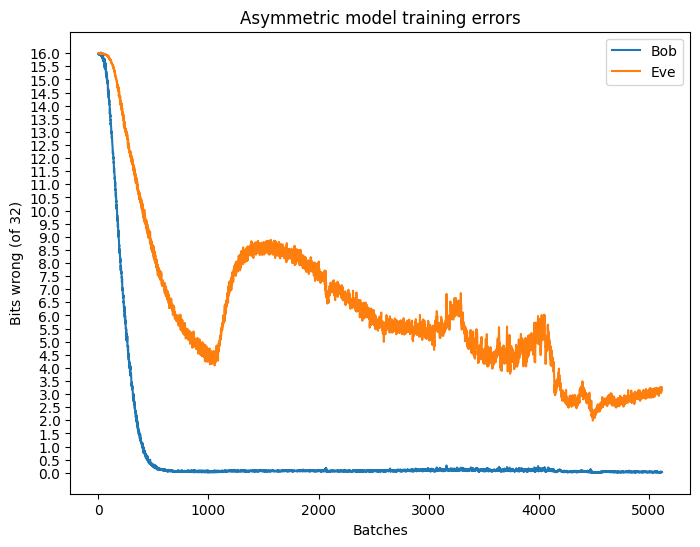

In [12]:
 encryption_system.plot_errors("train")

In [19]:
encryption_system.evaluate()


Evaluation: 100%|█████████| 256/256 [01:47<00:00,  2.39batch/s, alice_bob_loss=0.667, bob_error=0.0324, eve_error=3.25]

Evaluation finished (01:47)


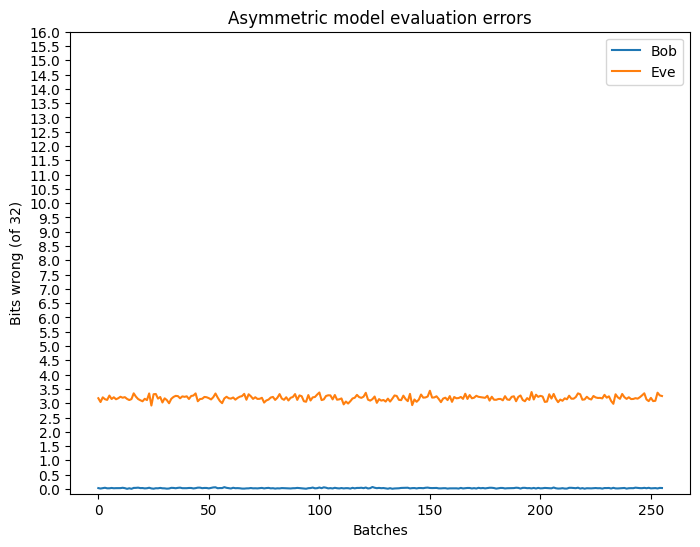

In [20]:
encryption_system.plot_errors("eval")


# Save Models

In [1]:
# Save models
# encryption_system.key_gen.save('key_gen.keras')
# encryption_system.alice.save('alice.keras')
# encryption_system.bob.save('bob.keras')
# encryption_system.eve.save('eve.keras')

# Text Processing Functions

In [13]:
def text_to_tensor(text: str, p_len: int) -> tuple[np.ndarray, int]:
    """Converts text to a binary tensor suitable for the model."""
    def char_to_binary(ch: str) -> list[int]:
        return [int(bit) for bit in format(ord(ch), "08b")] # we convert the chr to unicode with format 8bits and in final we add unicode after convert in list[].

    binary = np.array([char_to_binary(ch) for ch in text]).flatten() # apply the func in all text and put in 1D array.
    pad = (p_len - len(binary) % p_len) % p_len # sure that we need to add padding or not.
    tensor = np.concatenate([(binary * 2) - 1, np.zeros(pad)]) # convert the binary to [1,-1] and add padding if exisit.
    return tensor, pad

In [14]:
def tensor_to_text(tensor: np.ndarray, pad: int) -> str:
    """Converts a binary tensor back to text."""
    def binary_to_char(binary: np.ndarray) -> str:
        return chr(int("".join([str(bit) for bit in binary]), 2)) # Converts an 8-bit binary array to a Unicode character, (2) Converts binary string to decimal

    binary = np.round((tensor + 1) / 2.0).astype(int).flatten() # Shifts range from [-1,1] to [0,2], / 2.0: Normalizes to [0,1] range, np.round(): Rounds to nearest integer (0 or 1)

    binarys = [binary[i: i + 8] for i in range(0, len(binary) - pad, 8)] #Creates 8-bit chunks starting at positions 0, 8, 16,... || len(binary) - pad: Excludes padding bits from processing
    return "".join(map(binary_to_char, binarys)) # Applies binary_to_char to each 8-bit chunk and Combines resulting characters into final string


In [15]:
def asymmetric_encryption(config: Config, plaintext: str) -> tuple[str, str, str]:
    """Performs asymmetric encryption and decryption on the given plaintext."""
    tensor, pad = text_to_tensor(plaintext, config.P_LEN) # Converts input text to binary representation & Adds padding if needed to ensure proper length
    p_inputs = np.array(tensor).reshape(-1, config.P_LEN) #Reshapes tensor for model input, that means if the text higher than 32bit will be divided into multible rows
    pvk_inputs = np.random.choice([-1, 1], size=(len(p_inputs), config.K_LEN)) #  Generates random private keys (values -1 or 1)

    # Enceryption/Decryption operations.
    key_gen_output = encryption_system.key_gen.predict(pvk_inputs, verbose=0)
    alice_output = encryption_system.alice.predict([p_inputs, key_gen_output], verbose=0)
    bob_output = encryption_system.bob.predict([alice_output, pvk_inputs], verbose=0)
    eve_output = encryption_system.eve.predict([alice_output, key_gen_output], verbose=0)

    # Convert tensors to Text.
    ciphertext = tensor_to_text(alice_output, pad)
    plaintext_bob = tensor_to_text(bob_output, pad)
    plaintext_eve = tensor_to_text(eve_output, pad)

    return ciphertext, plaintext_bob, plaintext_eve

# Main

In [18]:
import sys
# Main Function
def main():
    """Main function to run the asymmetric encryption system."""
    #Test the system with varied plaintexts
    plaintext = [
    "Age 22",
    "Ahmed Ibrahim Mohamed Gawesh",
    ]
    # Test encryption/decryption
    print(sys.getsizeof(plaintext))
    for pt in plaintext:
        ciphertext, plaintext_bob, plaintext_eve = asymmetric_encryption(config, pt)
        print(f"Original: {pt}\nCipherText: {ciphertext}\nBob: {plaintext_bob}\nEve: {plaintext_eve}\n")
    # ciphertext, plaintext_bob, plaintext_eve = asymmetric_encryption(encryption_system, plaintext)
    # print(f"Plaintext: {plaintext}")
    # print(f"Ciphertext: {ciphertext}")
    # print(f"Plaintext (Bob): {plaintext_bob}")
    # print(f"Plaintext (Eve): {plaintext_eve}")

if __name__ == "__main__":
    main()

72
Original: Age 22
CipherText: 5:¾
Bob: Age 22
Eve: Acá 30

Original: Ahmed Ibrahim Mohamed Gawesh
CipherText: ¶b7"ð#Ø_t.
SôXu¢ãç#qÖ
Bob: Ahmed Ibrahim Mohamed Gawesh
Eve: @hiç` Iàraìil Iïlaéç` cásaóè

